# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 
.

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data?resource=download . Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv("C:/Users/Vladimir/Desktop/Ironhack_labs/Week18/lab-imbalance/your-code/Fraud.csv")

In [4]:
data = data.head(100000)

In [6]:
data.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
99995,10,PAYMENT,4020.66,C1410794718,159929.0,155908.34,M1257036576,0.00,0.00,0,0
99996,10,PAYMENT,18345.49,C744303677,6206.0,0.00,M1785344556,0.00,0.00,0,0
99997,10,CASH_IN,183774.91,C104331851,39173.0,222947.91,C36392889,54925.05,0.00,0,0
99998,10,CASH_OUT,82237.17,C707662966,6031.0,0.00,C1553004158,592635.66,799140.46,0,0
99999,10,PAYMENT,20096.56,C1868032458,110117.0,90020.44,M1419201886,0.00,0.00,0,0


In [14]:
data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [7]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,100000.0
mean,8.499640,1.736022e+05,8.777575e+05,8.940619e+05,8.805048e+05,1.184041e+06,0.001160,0.0
std,1.825545,3.443003e+05,2.673284e+06,2.711318e+06,2.402267e+06,2.802350e+06,0.034039,0.0
min,1.000000,3.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,8.000000,9.963562e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,9.000000,5.274552e+04,2.006150e+04,0.000000e+00,2.083943e+04,4.990918e+04,0.000000,0.0
75%,10.000000,2.117631e+05,1.901920e+05,2.148132e+05,5.882724e+05,1.058186e+06,0.000000,0.0
max,10.000000,1.000000e+07,3.379739e+07,3.400874e+07,3.400874e+07,3.894623e+07,1.000000,0.0


In [8]:
data["type"].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [13]:
data['isFlaggedFraud'].value_counts()

0    100000
Name: isFlaggedFraud, dtype: int64

In [17]:
data['isFraud'].value_counts()

0    99884
1      116
Name: isFraud, dtype: int64

### What is the distribution of the outcome? 

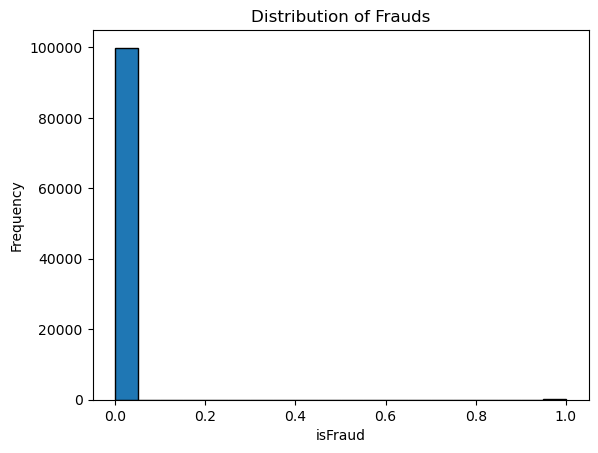

In [30]:
import matplotlib.pyplot as plt
plt.hist(data["isFraud"], bins=20, edgecolor='black')
plt.xlabel("isFraud")
plt.ylabel("Frequency")
plt.title("Distribution of Frauds")
plt.show()


### Clean the dataset. Pre-process it to make it suitable for ML training. Feel free to explore, drop, encode, transform, etc. Whatever you feel will improve the model score.

In [19]:
data.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [20]:
data.drop("nameOrig", axis = 1, inplace = True)
data.drop("nameDest", axis = 1, inplace = True)

In [23]:
data.dtypes

step                int64
type               object
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [24]:
data.isna().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [25]:
data_dummy = pd.get_dummies(data, columns=['type'])

In [29]:
data_dummy['step'].nunique()

10

In [34]:
data_dummy.drop("isFlaggedFraud", axis = 1, inplace = True)

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_13048\2537461712.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


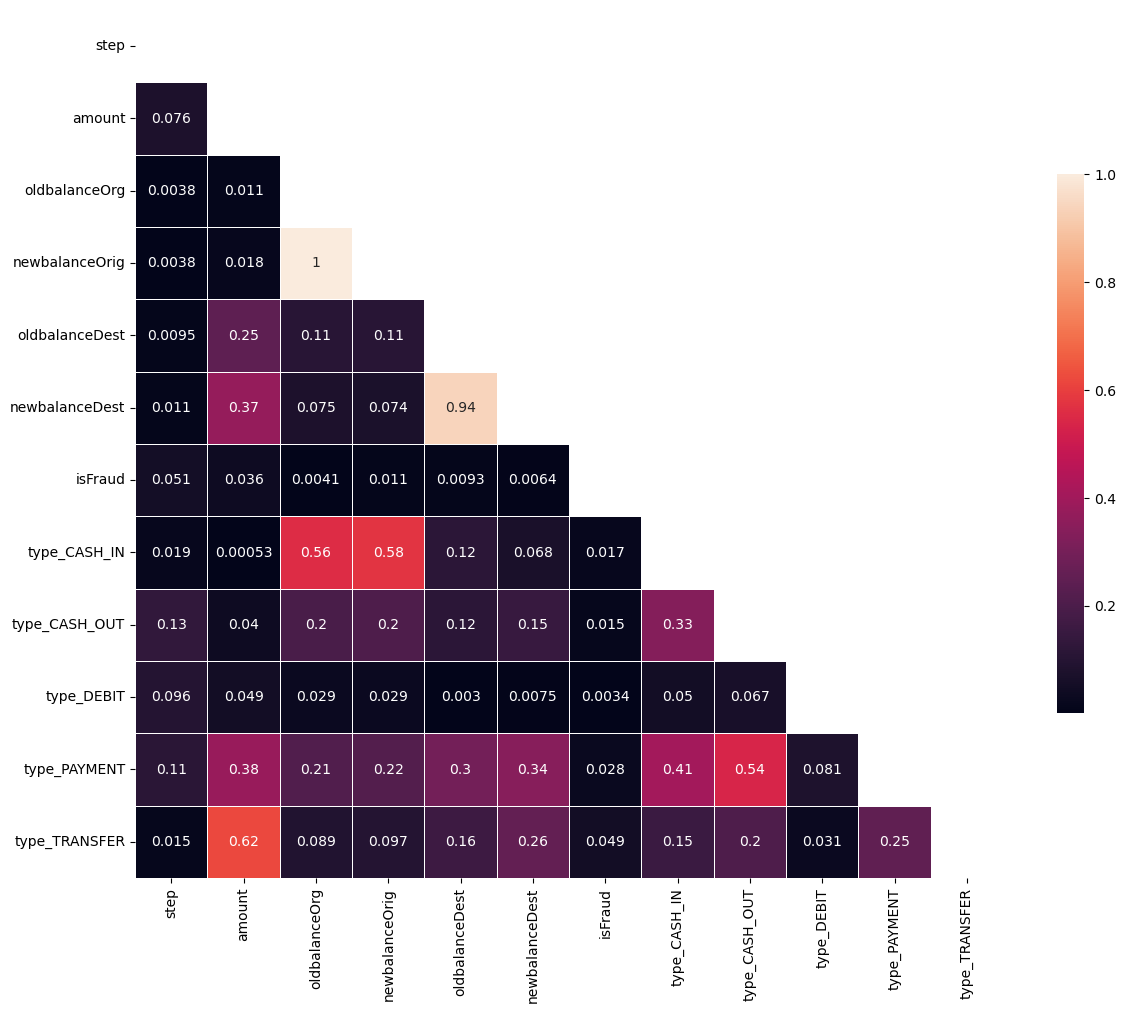

In [35]:
import seaborn as sn

corr=np.abs(data_dummy.corr())

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(14, 14))

cmap = sn.diverging_palette(220, 10, as_cmap=True)

sn.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

In [36]:
data_dummy.drop("oldbalanceDest", axis = 1, inplace = True)
data_dummy.drop("oldbalanceOrg", axis = 1, inplace = True)

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_13048\2537461712.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


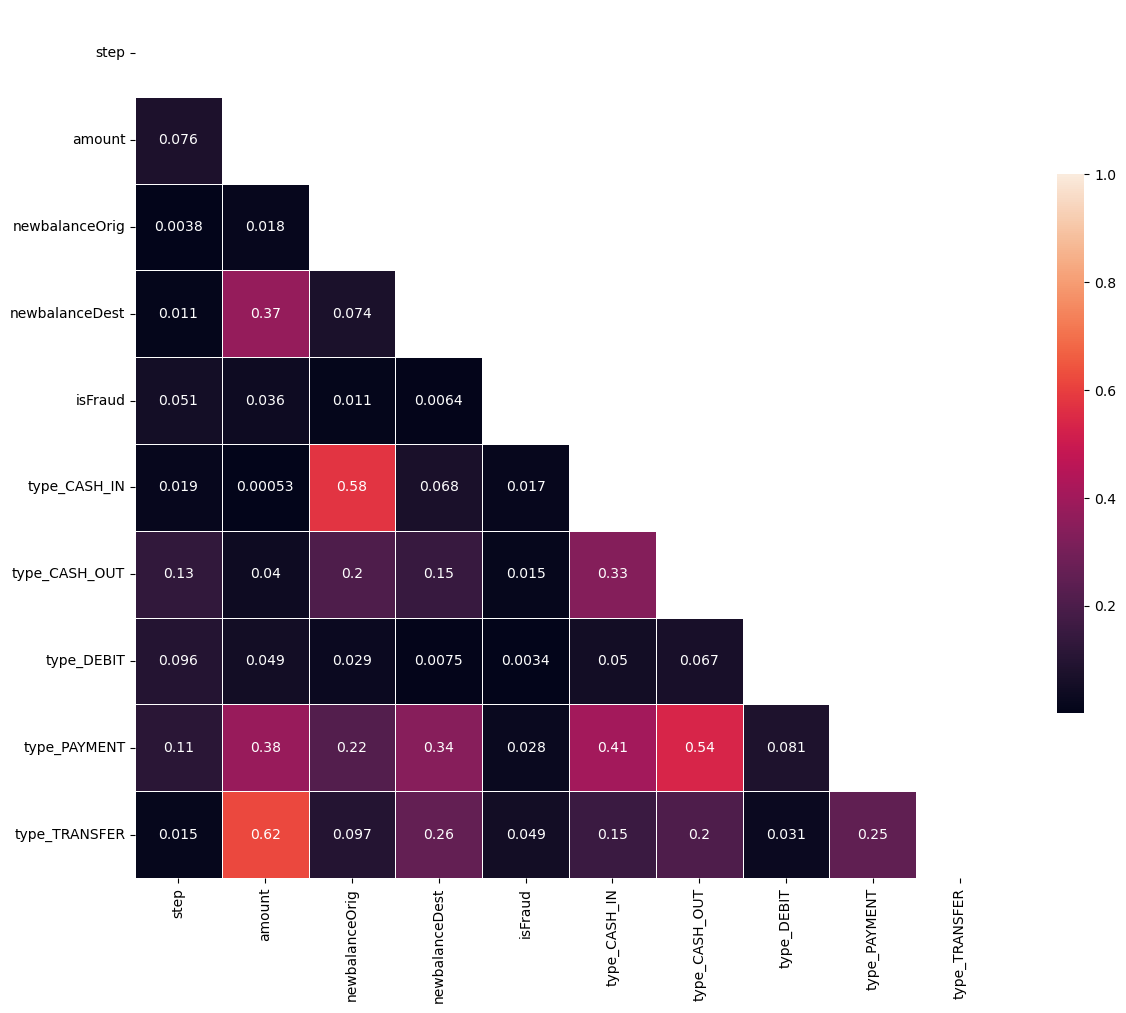

In [37]:
import seaborn as sn

corr=np.abs(data_dummy.corr())

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(14, 14))

cmap = sn.diverging_palette(220, 10, as_cmap=True)

sn.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

### Run a logisitc regression classifier and evaluate its accuracy.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = data_dummy.drop(columns=["isFraud"])  
y = data_dummy["isFraud"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.9987


### Now pick a model of your choice and evaluate its accuracy.

In [39]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42)


rf_classifier.fit(X_train, y_train)


y_pred = rf_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.9992


### Which model worked better and how do you know?

In [2]:
#the better accuracy score has random forrest, but its too high that is suspicious. Im sure I made a mistake somewhere.

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.